In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import lightgbm
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import early_stopping 

2024-11-11 08:46:41.557053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 08:46:41.557175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 08:46:41.713693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/feature-engineering/finaldatset.csv')


In [3]:
df.drop('DateRow', inplace=True , axis=1)

In [4]:
horizon=-7

In [5]:
target = df['Total_in'].shift(horizon)

target.dropna(inplace=True)

In [6]:
df.head()

,soi_shift_1,soi_shiftdiv_1,soi_shift_3,soi_shiftdiv_3,soi_shift_6,soi_shiftdiv_6,soi_shift_9,soi_shiftdiv_9,soi_shift_12,soi_shiftdiv_12,...,BareshBarf_in_shift_1_x_BareshBarf_in_shift_2,BareshBarf_in_shift_1_x_BareshBarf_in_shift_3,BareshBarf_in_shift_1_x_BareshBarf_in_shift_4,BareshBarf_in_shift_1_x_BareshBarf_in_shift_5,BareshBarf_in_shift_2_x_BareshBarf_in_shift_3,BareshBarf_in_shift_2_x_BareshBarf_in_shift_4,BareshBarf_in_shift_2_x_BareshBarf_in_shift_5,BareshBarf_in_shift_3_x_BareshBarf_in_shift_4,BareshBarf_in_shift_3_x_BareshBarf_in_shift_5,BareshBarf_in_shift_4_x_BareshBarf_in_shift_5
0,-0.7,1.166667,-0.7,1.166667,0.0,-0.0,2.2,-3.666667,0.1,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.7,1.166667,-0.7,1.166667,0.0,-0.0,2.2,-3.666667,0.1,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.7,1.166667,-0.7,1.166667,0.0,-0.0,2.2,-3.666667,0.1,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.7,1.166667,-0.7,1.166667,0.0,-0.0,2.2,-3.666667,0.1,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.7,1.166667,-0.7,1.166667,0.0,-0.0,2.2,-3.666667,0.1,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
y=target

x = df[:horizon]



In [8]:
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(0, inplace=True)

/tmp/ipykernel_18/781971186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_18/781971186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.fillna(0, inplace=True)


/tmp/ipykernel_18/3604388517.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  XGB_predictions = pd.concat([XGB_predictions, df_temp], ignore_index=True)


rmse: 0.4327933256499481
r2: 0.8192520363624839
mape: 0.19814463006320746
rmse: 0.46879130280017367
r2: 0.7946463977096873
mape: 0.21347225466260886
rmse: 0.16367604227906543
r2: 0.8423875370050733
mape: 0.1758451938924779
rmse: 0.7416179981736354
r2: 0.6273820183509096
mape: 0.22075202470935498
rmse: 0.4214657988255779
r2: 0.8378281646059522
mape: 0.26589047338200134
rmse: 0.7972816980033892
r2: 0.7302979516900818
mape: 0.29144413568710104
rmse: 0.26108265986312623
r2: 0.8076678651132282
mape: 0.15212564816996685
rmse: 0.3697240595770368
r2: 0.6919190309169589
mape: 0.23491289795902695
Weighted Average: 0.7908738948403085
rmsetest 0.4570541106464941
r2test: 0.7689226252192969
mapetest: 0.21907340731571817


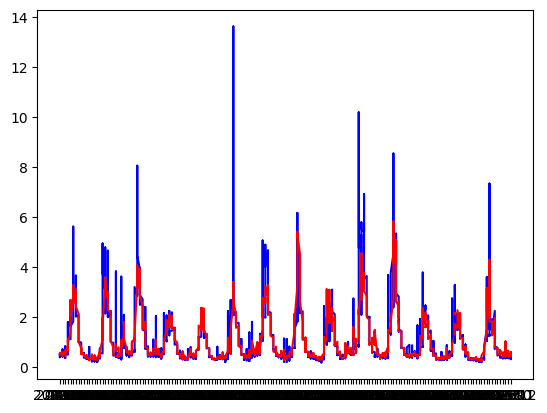

In [9]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []
test_mape=[]
XGB_predictions = pd.DataFrame(columns=['predictXGB'])
epsilon = 1e-6

i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        model = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=10, learning_rate=0.07,  max_depth= 15 ,colsample_bytree= 0.85,  n_jobs=4)
        
        model.fit(X_train, Y_train,sample_weight=X_train['meanbeforeyearTotal_in'], eval_set=[(X_test,Y_test)],verbose=False)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        test_r2.append (r2_score(Y_test, test_predict))
        
        df_temp = pd.DataFrame({'predictXGB': test_predict})

        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        XGB_predictions = pd.concat([XGB_predictions, df_temp], ignore_index=True)
        

        
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))

        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
weights=[1/(test_rmse+epsilon) for test_rmse in test_rmse]
weighted_sum = sum(w * r for w, r in zip(weights, test_r2))
total_weight = sum(weights)
weighted_average = weighted_sum / total_weight

print("Weighted Average:", weighted_average)

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




In [10]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

,Importance,Feature
2058,0.264710,meanbeforeyearTotal_in
2053,0.106230,Total_in
1601,0.015155,DarajeHararatTar6_5_rollingmax_120
581,0.013465,MinDarajehararat_in_rollingmax_120
2082,0.013094,MaxDarajehararat_in_shift_2_x_MaxDarajehararat...
240,0.010248,amo_rollingmin_6
93,0.010019,soi_rollingmax_12
2000,0.009969,Total_in_rollingmin_90
2115,0.008039,BareshBarf_in_shift_3_x_BareshBarf_in_shift_4
2074,0.008008,MaxDarajehararat_in_shift_1_x_MaxDarajehararat...


0 644
645 1287
0 1287
1288 1930
0 1930
1931 2573
0 2573
2574 3216
0 3216
3217 3859
0 3859
3860 4502
0 4502
4503 5145
0 5145
5146 5788
0 5788
5789 6431
0 6431
6432 7074
0 7074
7075 7717
0 7717
7718 8360
0 8360
8361 9003
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 0.0473595
rmse: 0.4232059179721466
r2: 0.8271713379009853
mape: 0.1718179153866361


/tmp/ipykernel_18/1018906581.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LGB_predictions =pd.concat([LGB_predictions, df_temp] , ignore_index=True)
/tmp/ipykernel_18/1018906581.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestSet =pd.concat([TestSet, test_temp] , ignore_index=True)


0 9003
9004 9646
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0699872
rmse: 0.4513125719326771
r2: 0.8096740102386402
mape: 0.20408063529985326
0 9646
9647 10289
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0254221
rmse: 0.13713903377805856
r2: 0.8893522731949585
mape: 0.15464626326849937
0 10289
10290 10932
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[180]	valid_0's l2: 0.0555713
rmse: 0.7065543744935433
r2: 0.6617837529911725
mape: 0.16707207316518655
0 10932
10933 11575
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0453123
rmse: 0.3689487452465742
r2: 0.8757252692415104
mape: 0.19420431921468728
0 11575
11576 12218
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[141]	vali

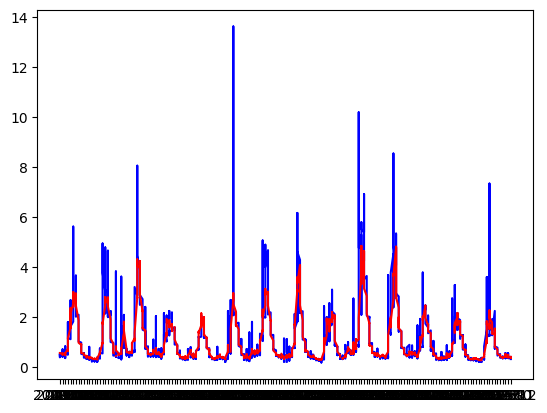

In [11]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []
test_mape=[]
LGB_predictions = pd.DataFrame(columns=['predictLGB'])
TestSet=pd.DataFrame(columns=['Test'])
i=0
epsilon = 1e-6

for train_index, test_index in tscv.split(x):
    i+=1
    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    print (train_index.min(),train_index.max())
    print (test_index.min(),test_index.max())
    if i>=13:
        lgb = lightgbm.LGBMRegressor( n_estimators=10000, num_leaves=40, learning_rate=0.04, colsample_bytree=0.9,verbose=0)

        lgb.fit(X_train, Y_train,sample_weight=X_train['meanbeforeyearTotal_in'], eval_set=(X_test,Y_test),callbacks=([early_stopping(stopping_rounds=60)]))

        test_predict = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
        
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        test_r2 .append ( r2_score(Y_test, test_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
  

        df_temp = pd.DataFrame({'predictLGB': test_predict})
        test_temp = pd.DataFrame({'Test': Y_test})

        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        LGB_predictions =pd.concat([LGB_predictions, df_temp] , ignore_index=True)
        TestSet =pd.concat([TestSet, test_temp] , ignore_index=True)
       
        
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
weights=[1/(test_rmse+epsilon) for test_rmse in test_rmse]
weighted_sum = sum(w * r for w, r in zip(weights, test_r2))
total_weight = sum(weights)
weighted_average = weighted_sum / total_weight

print("Weighted Average:", weighted_average)

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))



final=pd.concat ([LGB_predictions ,XGB_predictions, TestSet], axis=1) 
final['mean_column'] = ((final['predictLGB']*0.50) + (final['predictXGB']*0.49)) 

r2_score(final['Test'], final['mean_column'])


In [12]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

,Importance,Feature
2058,352,meanbeforeyearTotal_in
2053,113,Total_in
1976,97,Total_in_rollingmin_7
2055,85,day_of_year
586,61,MinDarajehararat_in_rollingmean_180
1974,55,Total_in_rollingmean_7
587,48,MinDarajehararat_in_rollingstd_180
1982,41,Total_in_rollingmean_30
581,39,MinDarajehararat_in_rollingmax_120
1984,37,Total_in_rollingmin_30


In [13]:

df.dropna(inplace=True, axis=1)
df.shape
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [14]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [15]:
target=df['Total_in'].shift(horizon)
y=target

#x = scaled_df. drop(columns =[ target ],axis=1)#,'index'

In [16]:
x=df.drop(columns=['Total_in'], axis=1)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_data, columns=x.columns)

In [18]:
x=scaled_df[:horizon]

In [19]:
x.shape

(13505, 2075)

In [20]:
y.dropna(inplace=True)

In [21]:
y.shape

(13505,)

rmse: 0.5341503864908467
r2: 0.7246789623178429
mape: 0.1846701304797832
rmse: 0.5180798021874938
r2: 0.749194788587054
mape: 0.2572444689706686
rmse: 0.17094654889238023
r2: 0.8280742210815739
mape: 0.189402069174795
rmse: 0.806515607369357
r2: 0.5593144207396914
mape: 0.2507342792715194
rmse: 0.4197132618720204
r2: 0.8391740447718619
mape: 0.23573341718834864
rmse: 0.8078890008067365
r2: 0.7230738001857075
mape: 0.2132768925691475
rmse: 1.0725569251573472
r2: -2.2459101789171663
mape: 0.5190803455153985
rmse: 0.41106884056176146
r2: 0.6191635028744338
mape: 0.19152740545646812
rmsetest 0.5926150466672429
r2test: 0.34959544520512487
mapetest: 0.2552086260782661


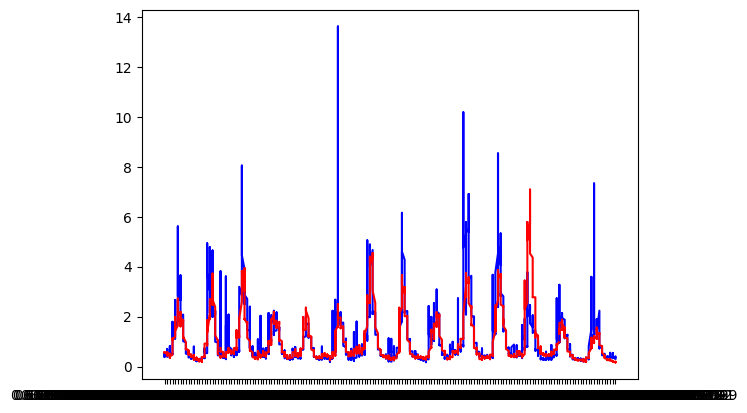

In [22]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []

test_mape=[]
MLP_predictions = pd.DataFrame(columns=['predictMLP'])
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        mlp = MLPRegressor(hidden_layer_sizes=( 512, 256), activation='relu', solver='adam', max_iter=300,learning_rate='constant', early_stopping=True,alpha=  0.0001 , batch_size=64)

        mlp.fit(X_train, Y_train )

        test_predict = mlp.predict(X_test)
        
        
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000  
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))

        MLP_predictions = pd.DataFrame({'predictMLP': test_predict})
        
        
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




rmse: 0.5211509200268827
r2: 0.7379167163585862
mape: 0.1778356655042544
rmse: 0.5062554522594199
r2: 0.760512604547389
mape: 0.21124356256646407
rmse: 0.19491617095332095
r2: 0.7764801651129838
mape: 0.1930176780718029
rmse: 0.7732028725282903
r2: 0.594967190417244
mape: 0.20957266625476217
rmse: 0.3834458703485511
r2: 0.865767127099495
mape: 0.18795351003439562
rmse: 0.8033971893361509
r2: 0.7261446237180544
mape: 0.17165926708234722
rmse: 0.2709146536048572
r2: 0.7929092085149784
mape: 0.14008645746595605
rmse: 0.3783878772623668
r2: 0.6773112134002908
mape: 0.1841405561771365
rmsetrain: 0.189195229773309 rmsetest 0.24817586260210447
r2train: 0.9379305531137718 r2test: 0.8554791238592642
mapetest: 0.024401583780654997


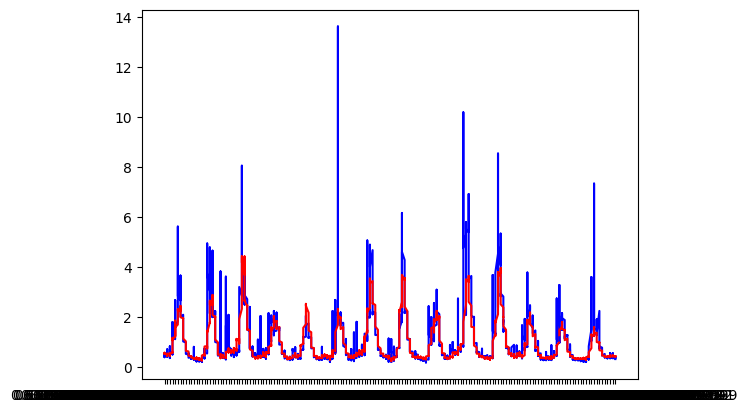

In [23]:
scv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
predictSVR=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)

        # آموزش مدل
        svr.fit(X_train, Y_train)

        # پیش‌بینی
        test_predict = svr.predict(X_test)
        train_predict = svr.predict(X_train)
        predictSVR.append(test_predict)
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))